# House Price Competition - Predicting Prices

This notebook is designed to predict prices for the House Price Competition. If you use this notebook or find it helpful, **please give it an upvote!**

I have created a step-by-step data exploration notebook for this competition [here](https://www.kaggle.com/thomaswoolley/house-price-data-exploration). If you have not read that one, I would strongly recommend doing so before working through this notebook.

If you like my work my other, notebooks on various topics can be found on Kaggle [here](https://www.kaggle.com/thomaswoolley/notebooks) and GitHub [here](https://github.com/Woolley12345/kaggle-competitions).


### Competition Overview

The aim of this competition is to predict the sales price of various houses given a number of features. This makes this a regression problem (predicting a continuous variable e.g. price) rather than a classification problem (predicting distinct classes/groups e.g. survived or not). In order to approach this competition, it was essential to first understand the data that we are working with. This notebook builds on that understanding and uses it to make predictions about the final house prices.

### Notebook Structure
This notebook is structured as follows:

1. Load Modules and Data
2. Data Cleaning
3. Feature Engineering
4. Fitting Models to the Data
5. Generating Submission Files



# 1. Load Modules and Data

As the first step, we have to load in the data that we want to use. It is also important to load in some modules. Modules help us to do additional things with Python such as plotting, mathematics and data processing. Some commonly used modules are imported below to help us explore the data we have been given. For more information on the modules that are used here, check out the documentation at the following links:

* [Numpy](https://numpy.org)
* [Pandas](https://pandas.pydata.org)
* [MatplotLib](https://matplotlib.org)
* [Seaborn](https://seaborn.pydata.org)

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing
import matplotlib.pyplot as plt #plottting
import seaborn as sns # more plotting

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv
/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt


The output of the above cell provides us with the paths to the data files that we wish to import. They are saved as *.csv* files and so all we have to do is use the *read_csv* option in the *Pandas* module. The following code saves the data as a *Pandas Dataframe* (you can imagine it like a table of data) with the variable name *all_data*. 

We choose to combine the training and test data here so that we only have to write the feature engineering code once. However, we will track the test data (as we can fill the SalePrice features with NaN values in the Dataframe), and separate it before fitting our models.

In [2]:
# Load in both the training and test data 
train_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test_data = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")

# Add the missing column to the test data but just fill it with NaNs so we can separate it later
test_data['SalePrice'] = np.nan

# Combine the two dataframes
all_data = pd.concat([train_data, test_data])

# Check the lengths are as expected
print("Rows in train data = {}".format(len(train_data)))
print("Rows in test data = {}".format(len(test_data)))

Rows in train data = 1460
Rows in test data = 1459


# 2. Data Cleaning

Let's start by removing columns that have a lot of missing data and therefore would be very difficult to fill. This just keeps the dataframe smaller and easier to handle.

In [3]:
# Check for NaNs in the data
print("NaNs in each training Feature")
dfNull = all_data.isnull().sum().to_frame('nulls')
print(dfNull.loc[dfNull['nulls'] > 0]) # Print only features that have Null values

NaNs in each training Feature
              nulls
MSZoning          4
LotFrontage     486
Alley          2721
Utilities         2
Exterior1st       1
Exterior2nd       1
MasVnrType       24
MasVnrArea       23
BsmtQual         81
BsmtCond         82
BsmtExposure     82
BsmtFinType1     79
BsmtFinSF1        1
BsmtFinType2     80
BsmtFinSF2        1
BsmtUnfSF         1
TotalBsmtSF       1
Electrical        1
BsmtFullBath      2
BsmtHalfBath      2
KitchenQual       1
Functional        2
FireplaceQu    1420
GarageType      157
GarageYrBlt     159
GarageFinish    159
GarageCars        1
GarageArea        1
GarageQual      159
GarageCond      159
PoolQC         2909
Fence          2348
MiscFeature    2814
SaleType          1
SalePrice      1459


In [4]:
# Drop the features with lots of NaNs
all_data.drop(columns=['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature'], inplace=True)

# 3. Feature Engineering

Let's fill some of the missing values and make the data ready for models.

## 3.1. Converting Quality and Condition to Numerical Fields
There are some features which have quality and condition measured as a number and others with them measured with text-based categories. Here we should convert them all to numbers to make it more consistent. The features that we remap in this section are:
1. KitchenQual
2. BsmtQual
3. BsmtCond
4. GarageQual
5. GarageCond

In [5]:
# Create mapping which works for Kitchen, Garage and Basement
mapping = {'Ex': 5.0, 'Gd': 4.0, 'TA': 3.0, 'Fa': 2.0, 'Po': 1.0}

# Remap values
all_data.replace({'KitchenQual': mapping}, inplace=True)
all_data.replace({'BsmtQual': mapping}, inplace=True)
all_data.replace({'BsmtCond': mapping}, inplace=True)
all_data.replace({'GarageQual': mapping}, inplace=True)
all_data.replace({'GarageCond': mapping}, inplace=True)

## 3.2. Filling Missing Values

In this section we fill the missing values. Most of the missing values are filled using the most common value for brevity however, we could test out other ways of filling missing values to improve the models. This has been left for future notebooks.

### 3.2.1. MSZoning, Utilities and Electrical (4, 2 and 1 missing values respectively)
Let's start with these features and check their distributions.


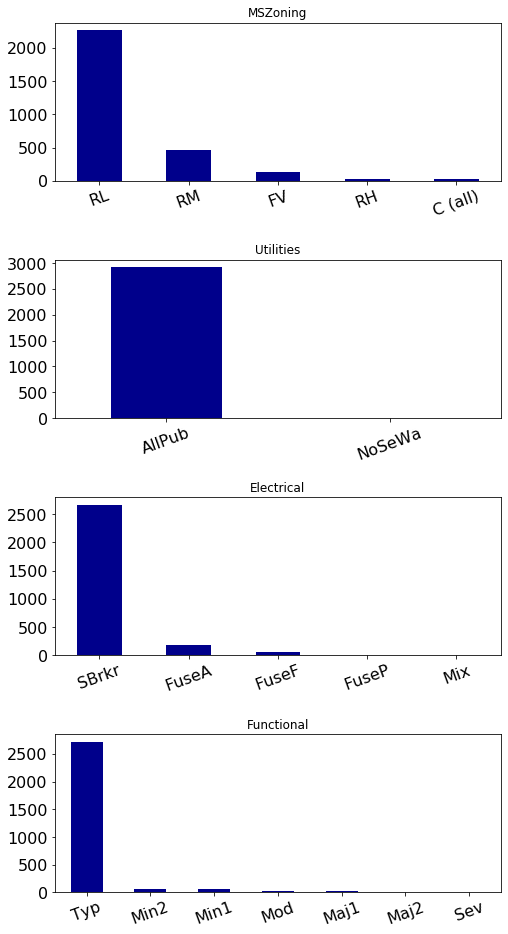

In [6]:
# Plot the distributions
keys = ['MSZoning', 'Utilities', 'Electrical', 'Functional']
fig, axs = plt.subplots(4,1, figsize=(8,16))
axs = axs.flatten()
for i in range(len(keys)):
    all_data[keys[i]].value_counts().plot(kind='bar', rot=20.0, fontsize=16, color='darkblue', 
                                          title=keys[i], ax=axs[i])
fig.subplots_adjust(hspace=0.5)
plt.show()

The over whelming majority of data for the MSZoning feature takes a value of "RL" so let's fill the missing data with this value. As we only have 4 data points to fill this is probably sufficient for this feature but we could always come back and do a more technical filling of the data based on correlations.

As the Utilities feature almost always takes the value "AllPub" we can drop this feature rather than filling in the missing values. This is because if all the data takes the same value of a feature, that feature does not provide any informaion for the model.

As we only have one missing Electrical value we can fill it with the most common value ("SBrkr").

The Functional feature takes the value "Typ" the majority of the time so let's fill the missing values with this.

In [7]:
# MSZoning: Fill the NaNs with RL
all_data['MSZoning'].fillna('RL', inplace=True)

# Utilities: Drop the feature
all_data.drop(columns=['Utilities'], inplace=True)

# Electrical: Fill the NaNs with SBrkr
all_data['Electrical'].fillna('SBrkr', inplace=True)

# Functional: Fill the NaNs with Typ
all_data['Functional'].fillna('Typ', inplace=True)

### 3.2.2. Exterior1st and Exterior2nd (1 missing value each)

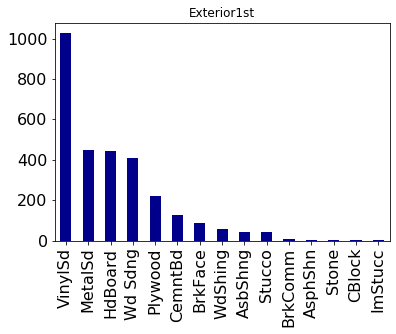

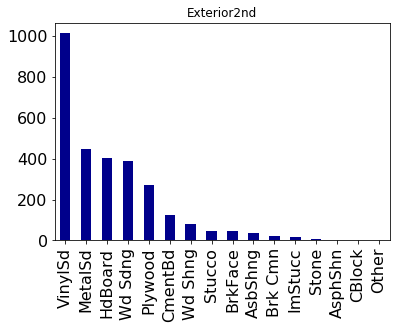

In [8]:
# Plot the distributions
all_data['Exterior1st'].value_counts().plot(kind='bar', rot=90.0, fontsize=16, color='darkblue', title='Exterior1st')
plt.show()

all_data['Exterior2nd'].value_counts().plot(kind='bar', rot=90.0, fontsize=16, color='darkblue', title='Exterior2nd')
plt.show()

In [9]:
# Check if both exteriors are missing for the same property
print(all_data['Exterior2nd'].values[all_data['Exterior1st'].isnull() == True])

[nan]


Okay so this tells us that the Exterior features are missing for the same property. This is also one of the properties that we are trying to predict the SalePrice of so we cannot remove it. Let's just fill it with the most common Exterior value for now.

In [10]:
# Fill the NaNs with VinylSd
all_data['Exterior1st'].fillna('VinylSd', inplace=True)
all_data['Exterior2nd'].fillna('VinylSd', inplace=True)

### 3.2.3. MasVnrType and MasVnrArea (24 and 23 missing values respectively)

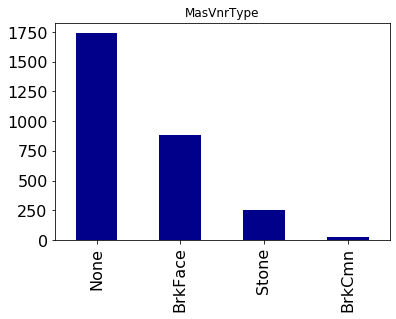

In [11]:
# Plot the distribution
all_data['MasVnrType'].value_counts().plot(kind='bar', rot=90.0, fontsize=16, color='darkblue', title='MasVnrType')
plt.show()

Fill with the most common result which is None. This also means the MasVnrArea feature will be zero for these if it takes a NaN value. Let's check what values of the MasVnrArea feature are available when we have NaNs for the MasVnrType feature.

In [12]:
# Find the vales of MasVnrArea when MasVnrType is Nan
print(all_data['MasVnrArea'].values[all_data['MasVnrType'].isnull() == True])

[ nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan  nan
  nan  nan  nan  nan  nan  nan 198.  nan  nan  nan]


We can see that most of the MasVnrArea values are NaN too, but there is one that is not. Let's fill the MasVnrArea=198 case with the most common MasVnrType (which is BrkFace) and fill the rest with MasVnrArea=0.0 and MasVnrType=None.

In [13]:
# Find the indices that correspond to the NaNs in MasVnrType but values in MasVnrArea (i.e. the MasVnrArea=198 index)
indices = (np.argwhere((all_data['MasVnrType'].isnull().values) & (all_data['MasVnrArea'].isnull().values == False))).flatten()
print(indices)

# Now fill the MasVnrType corresponding to MasVnrArea != NaN with BrkFace
all_data.iloc[indices[0], all_data.columns.get_loc('MasVnrType')] = 'BrkFace'

# And fill the remaining MasVnrType and MasVnrArea
all_data['MasVnrType'].fillna('None', inplace=True)
all_data['MasVnrArea'].fillna(0.0, inplace=True)

[2610]


### 3.2.4. Basement Categorical Features
The categorical features relating to the basement of the houses are:
1. BsmtQual (81 missing values)
2. BsmtCond (82 missing values)
3. BsmtExposure (82 missing values)
4. BsmtFinType1 (79 missing values)
5. BsmtFinType2 (80 missing values)
6. BsmtFullBath (2 missing values)
7. BsmtHalfBath (2 missing values)

Let's check out the distributions of these.

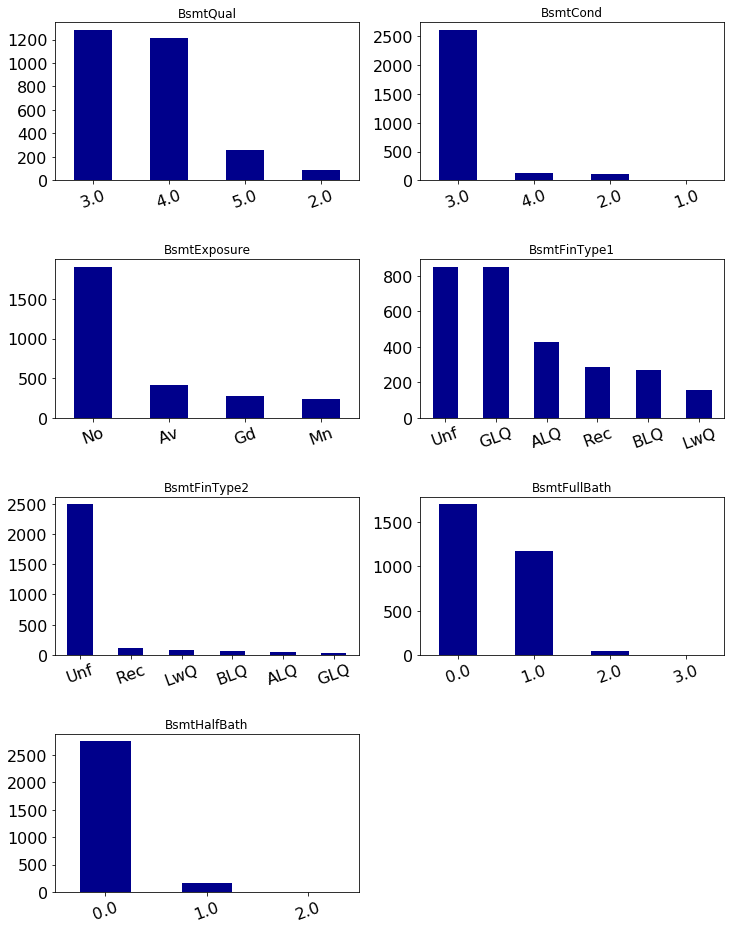

In [14]:
# Plot the distributions
keys = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2','BsmtFullBath', 'BsmtHalfBath']
fig, axs = plt.subplots(4,2, figsize=(12,16))
axs = axs.flatten()
for i in range(len(keys)):
    all_data[keys[i]].value_counts().plot(kind='bar', rot=20.0, fontsize=16, color='darkblue', 
                                          title=keys[i], ax=axs[i])
fig.subplots_adjust(hspace=0.5)
fig.delaxes(axs[-1]) # remove the extra subplot (only need 7 but created 8)
plt.show()

Now as BsmtCond is almost always 3.0, let's replace the NaNs with 3.0. Let's fill the rest with the most common values too.

In [15]:
# Fill the BsmtCond values with 3.0
all_data['BsmtCond'].fillna(3.0, inplace=True)

# Fill the rest
all_data['BsmtQual'].fillna(3.0, inplace=True)
all_data['BsmtExposure'].fillna('No', inplace=True)
all_data['BsmtFinType1'].fillna('Unf', inplace=True)
all_data['BsmtFinType2'].fillna('Unf', inplace=True)
all_data['BsmtFullBath'].fillna(0.0, inplace=True)
all_data['BsmtHalfBath'].fillna(0.0, inplace=True)

### 3.2.5. KitchenQual (1 missing value)

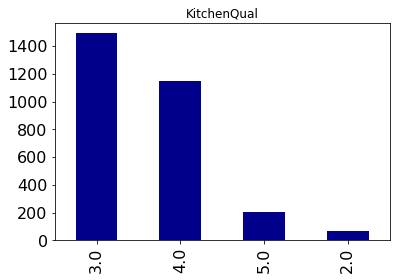

In [16]:
# Plot the distribution
all_data['KitchenQual'].value_counts().plot(kind='bar', rot=90.0, fontsize=16, color='darkblue', title='KitchenQual')
plt.show()

Check the KitchenQual correlations

In [17]:
# Find the 5 largest correlations to KitchenQual
bigCorr = all_data.corr().nlargest(5, 'KitchenQual')['KitchenQual']
print(bigCorr)

# Find the 5 largest anti-correlations to KitchenQual
bigAnti = all_data.corr().nsmallest(5, 'KitchenQual')['KitchenQual']
print(bigAnti)

KitchenQual     1.000000
OverallQual     0.676149
SalePrice       0.659600
YearRemodAdd    0.613899
BsmtQual        0.593339
Name: KitchenQual, dtype: float64
KitchenAbvGr    -0.169973
EnclosedPorch   -0.127369
BsmtHalfBath    -0.057877
OverallCond     -0.053102
BsmtFinSF2      -0.045542
Name: KitchenQual, dtype: float64


Okay so we know that OverallQual is closely correlated to the KitchenQual and so we can fill missing values using the OverallQual.



In [18]:
# Calculate the mean of the KitchenQual feature and round to the nearest integer (i.e. nearest quality category)
meanKitchenQual = np.rint(all_data.groupby(['OverallQual'])['KitchenQual'].mean())
print(meanKitchenQual)

# Check what OverallQual is for the missing KitchenQual value
print(all_data['OverallQual'].values[np.isnan(all_data['KitchenQual'].values)])

# Fill the missing KitchenQual value
all_data['KitchenQual'].fillna(3.0, inplace=True)

OverallQual
1     2.0
2     3.0
3     3.0
4     3.0
5     3.0
6     3.0
7     4.0
8     4.0
9     5.0
10    5.0
Name: KitchenQual, dtype: float64
[5]


### 3.2.6. Garage Categorical Features

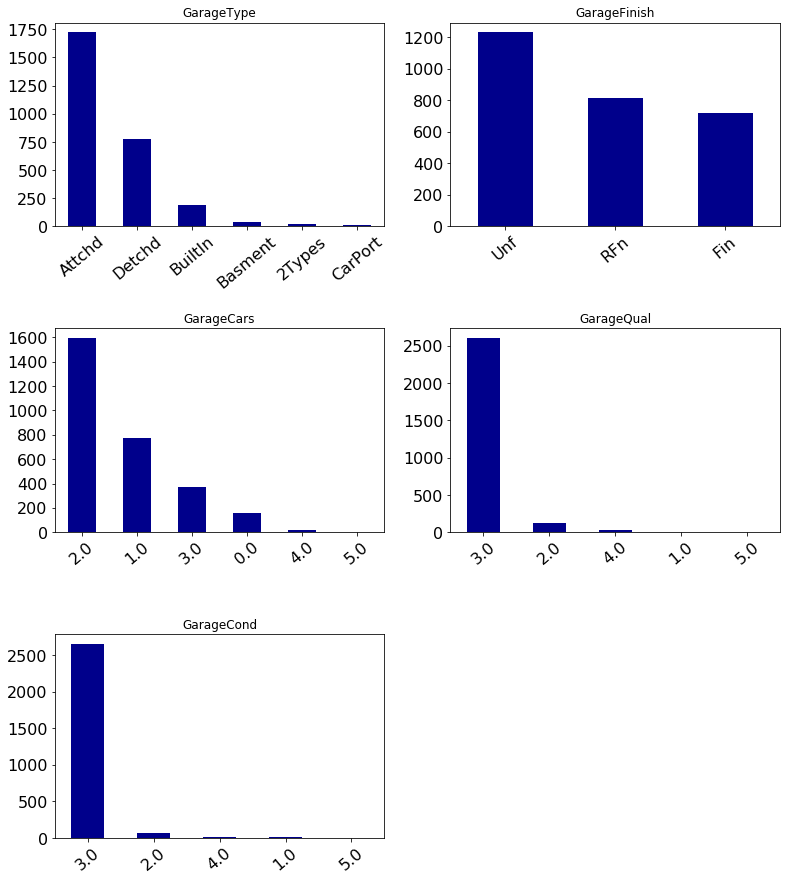

In [19]:
# Plot the categorical features
fig, axs = plt.subplots(3,2, figsize=(13,15))
axs = axs.flatten()
keys = ['GarageType', 'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond']
for i in range(len(keys)):
    all_data[keys[i]].value_counts().plot(kind='bar', rot=40.0, fontsize=16, color='darkblue', 
                                                   title=keys[i], ax=axs[i])
fig.subplots_adjust(hspace=0.5)
fig.delaxes(axs[-1]) # remove the extra subplot (only need 5 but created 6)
plt.show()

In [20]:
# Fill with most common values 
all_data['GarageType'].fillna('Attchd', inplace=True)
all_data['GarageFinish'].fillna('Unf', inplace=True)
all_data['GarageCars'].fillna(2.0, inplace=True)
all_data['GarageQual'].fillna(3.0, inplace=True)
all_data['GarageCond'].fillna(3.0, inplace=True)

### 3.2.7. Basement Continuous Features
The following continuous features related to the basement:
1. BsmtFinSF1 (1 missing value)
2. BsmtFinSF2 (1 missing value)
3. BsmtUnfSF (1 missing value)
4. TotalBsmtSF (1 missing value)

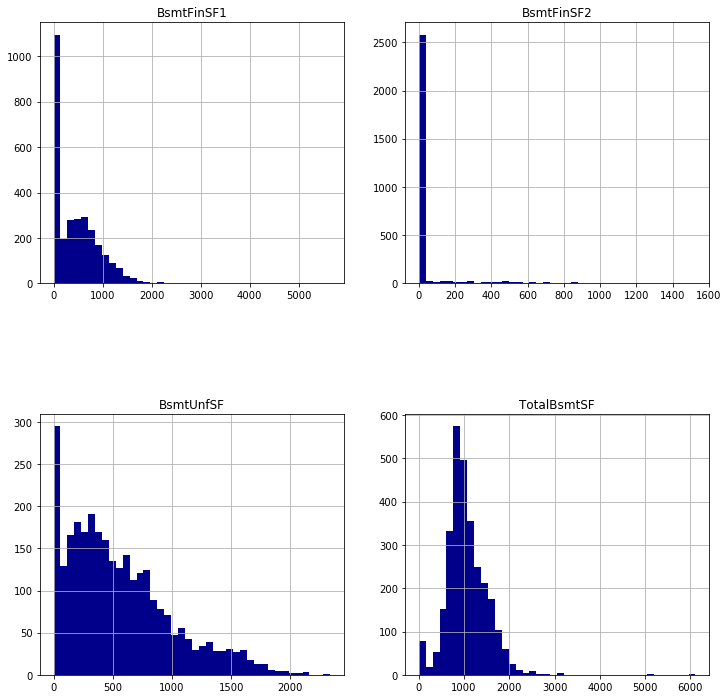

In [21]:
# Sort this plotting out so it looks good
keys = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
# Plot the continuous distributions
fig, axs = plt.subplots(2,2, figsize=(12,12))
axs = axs.flatten()
for i in range(len(keys)):
    all_data[keys[i]].hist(color='darkblue', ax=axs[i], bins=40)
    axs[i].set_title(keys[i])
fig.subplots_adjust(hspace=0.5)
plt.show()

Now check if the NaNs are all for the same property

In [22]:
# Check which indices are NaN for each features
for i in keys:
    print(np.argwhere(np.isnan(all_data[i].values)))

[[2120]]
[[2120]]
[[2120]]
[[2120]]


Okay. So we can see that the missing values are all for the same property. Let's just fill the values with 0 for BsmtFinSF2. We can fill the missing values of BsmtFinSF1, TotalBsmtSF and BsmtUnfSF with the median of the distribution.

In [23]:
# Calculate median
median_total = np.median(all_data['TotalBsmtSF'].values[~np.isnan(all_data['TotalBsmtSF'].values)])
median_SF1 = np.median(all_data['BsmtFinSF1'].values[~np.isnan(all_data['BsmtFinSF1'].values)])
median_Unf = np.median(all_data['BsmtUnfSF'].values[~np.isnan(all_data['BsmtUnfSF'].values)])
print(median_total, median_SF1, median_Unf)

# Fill the missing values
all_data['BsmtFinSF1'].fillna(median_SF1, inplace=True)
all_data['BsmtFinSF2'].fillna(0.0, inplace=True)
all_data['BsmtUnfSF'].fillna(median_Unf, inplace=True)
all_data['TotalBsmtSF'].fillna(median_total, inplace=True)

989.5 368.5 467.0


### 3.2.8. Garage Continuous Features

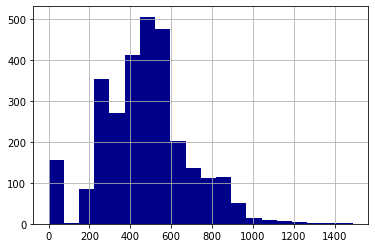

In [24]:
keys = [ 'GarageYrBlt', 'GarageArea']
# Plot the distribution
all_data['GarageArea'].hist(color='darkblue', bins=20)
plt.show()

If GarageYrBlt is not available just set this as the same year the house was built (YearBuilt)

In [25]:
# Find the NaNs
garage_yr_built = all_data['GarageYrBlt'].values
indices = np.argwhere(np.isnan(garage_yr_built))

# Update the data
yearbuilt = all_data['YearBuilt'].values[indices]
garage_yr_built[indices] = yearbuilt

# Save to the dataframe
all_data['GarageYrBlt'] = garage_yr_built


# Fill area with median
median = np.median(all_data['GarageArea'].values[~np.isnan(all_data['GarageArea'].values)])
print(median)
all_data['GarageArea'].fillna(median, inplace=True)

480.0


### 3.2.9. SaleType (1 missing value)

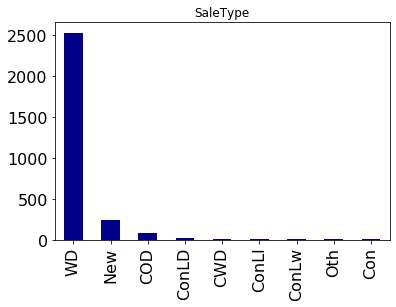

In [26]:
# Plot the distribution
all_data['SaleType'].value_counts().plot(kind='bar', rot=90.0, fontsize=16, color='darkblue', title='SaleType')
plt.show()

# Fill with the most common value
all_data['SaleType'].fillna('WD', inplace=True)

### 3.2.10. LotFrontage (486 missing values)

In [27]:
# Fill Frontage with median
median = np.median(all_data['LotFrontage'].values[~np.isnan(all_data['LotFrontage'].values)])
print(median)
all_data['LotFrontage'].fillna(median, inplace=True)

68.0


In [28]:
# Check everything has been filled as expected
print(all_data.isnull().sum().values)

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1459]


Here we can see that there are no NaNs except for the last feature. This last feature is the SalePrice that we are trying to predict for the test set.

## 3.3. Expanding Existing Features

Let's expand some of the features which could provide some helpful information for the model. This part can take the most time and can really improve model accuracy. Here we will just do some fairly simple things but it is possible to do much more advanced feature enegineering.

In [29]:
# ==== Get features ready for one-hot encoding
# MoSold
mapping = {1: 'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 
           8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
all_data.replace({'MoSold': mapping}, inplace=True)

# MSSubClass
mapping = {20:'A', 30:'B', 40:'C', 45:'D', 50:'E', 60:'F', 70:'G', 75:'H', 80:'I', 85:'J', 
           90:'K', 120:'L', 150:'M', 160:'N', 180:'O', 190:'P'}
all_data.replace({'MSSubClass': mapping}, inplace=True)


# ==== Create some new features
all_data['sale_age'] = 2020 - all_data['YrSold'] 
all_data['house_age'] = 2020 - all_data['YearBuilt'] 
all_data['remodel_age'] = 2020 - all_data['YearRemodAdd']
all_data['garage_age'] = 2020 - all_data['GarageYrBlt']
all_data.drop(columns=['YrSold', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt'], inplace=True)


all_data['TotalArea'] = (all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']
                         + all_data['GrLivArea'] + all_data['GarageArea'])
all_data['TotalBathrooms'] = all_data['FullBath'] + all_data['HalfBath']*0.5 

## 3.4. Handling Categorical Text Data 

One way of handling categorical text data is to use one-hot encoding. This creates a new column for each possible value of a feature. The columns are filled with a 1 or a 0 depending on whether the feature takes that value.

Below we do one-hot encoding on all the text based categorical features in the dataset.

In [30]:
# Specify which columns to one hot encode
columns = ['MSZoning', 'MSSubClass', 'PavedDrive', 'GarageFinish', 'Foundation', 'Functional', 'LandContour', 'Condition1', 
           'Condition2', 'Street', 'LotShape', 'ExterQual', 'ExterCond', 'LotConfig', 'LandSlope', 'Neighborhood','BldgType',
           'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st','Exterior2nd', 'MasVnrType', 'BsmtExposure', 'BsmtFinType1',
           'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'GarageType', 'SaleType', 'SaleCondition', 
           'MoSold']

# Do the encoding
one_hot = pd.get_dummies(all_data.loc[:, columns], drop_first=True)
all_data.drop(columns=columns, inplace=True)
for i in range(len(one_hot.columns.values)):
    all_data[one_hot.columns.values[i]] = one_hot[one_hot.columns.values[i]].values

# 4. Fitting Models to the Data

## 4.1. Preparing the Data

We now need to get our data ready for the model. To do this, we should separate the data used for training and testing our model from the data used to make house price predictions.

In [31]:
# Separate the data into prediction and model data
predict_data = all_data.loc[np.isnan(all_data['SalePrice'].values)]
model_data = all_data.loc[~np.isnan(all_data['SalePrice'].values)]
predict_ids = predict_data['Id'].values

# Remove ID so that the model is not trained on this. We add this back into the data before submission
predict_data.drop(columns=['Id'], inplace=True)
model_data.drop(columns=['Id'], inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


We can also remove some outliers to improve how our model is trained. This code is adapted from this notebook: https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

In [32]:
# Remove outliers from the training data 
from collections import Counter

def detect_outliers(df,n,features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25) # 1st quartile (25%)
        Q3 = np.percentile(df[col],75) # 3rd quartile (75%)
        IQR = Q3 - Q1 # Interquartile range (IQR)
        outlier_step = 1.5 * IQR # outlier step
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
    # select observations containing more than n outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers 

# Detect outliers from SalePrice, LotArea, GarageArea
Outliers_to_drop = detect_outliers(model_data,1,["SalePrice", 'LotArea', 'GarageArea'])
model_data = model_data.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

Now we need to scale the training and prediction datasets by the same amount. This scales all the data to take values between 0 and 1, which ensures features with larger numerical values are not incorrectly favoured over features with smaller numerical values.

In [33]:
# Scale the data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(model_data.drop(columns=['SalePrice']))
X_train = scaler.transform(model_data.drop(columns=['SalePrice']))
y_train = model_data['SalePrice'] 

X_predict_data_scaled = scaler.transform(predict_data.drop(columns=['SalePrice']))

## 4.2. Random Forest Regression

Let's now fit the RandomForestRegressor to the model dataset in order to make predictions about the house prices. First we need to import the required modules. We use GridSearchCV here to search for the best model hyperparameters to fit the data. 

In [34]:
# Import some required modules for the fitting
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [35]:
# Search for the optimal hyperparameters for RF
param_grid = { 
    'criterion' : ['mse'],
    'n_estimators': [90, 100, 110],
    'max_features': ['auto', 'log2'],
    'max_depth' : [7, 9, 11, 13]    
                }

randomForest_CV = GridSearchCV(estimator = RandomForestRegressor(), param_grid = param_grid, cv = 3)
randomForest_CV.fit(X_train, y_train)
print(randomForest_CV.best_params_)

# Print the best score
print(randomForest_CV.best_score_)

# Get the parameters from the best fit
criterion = randomForest_CV.best_params_.get('criterion')
nRF = randomForest_CV.best_params_.get('n_estimators')
max_features = randomForest_CV.best_params_.get('max_features')
max_depth = randomForest_CV.best_params_.get('max_depth')

# Train the classifier on all the data for predicting the test data (use best hyperparams)
bestRF = RandomForestRegressor(n_estimators=nRF, max_depth=max_depth, max_features=max_features, criterion=criterion)
bestRF.fit(X_train, y_train)

{'criterion': 'mse', 'max_depth': 11, 'max_features': 'auto', 'n_estimators': 110}
0.8586406035740607


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=11, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=110, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

## 4.3. XGBoost Regression

Now we can also try the XGBoostRegressor and see how this performs. We haven't bothered tuning the hyperparamters here but this is something that could be implemented.

In [36]:
import xgboost as xgb
xgboost = xgb.XGBRegressor(learning_rate=0.01,n_estimators=3460,
                                    max_depth=3)
xgboost.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=3460, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

# 5. Generating Submission Files

Now that we have trained our models, we need to use them to make predictions and then generate submission files with these predictions.

In [37]:
# Use the models to predict the output of the test data
testPredictionsRF = bestRF.predict(X_predict_data_scaled)
testPredictionsXGB = xgboost.predict(X_predict_data_scaled)

# Save the outputs to csv files
outputRF = pd.DataFrame({'Id': predict_ids, 'SalePrice': testPredictionsRF})
outputRF.to_csv('my_submissionRF.csv', index=False)

outputXGB = pd.DataFrame({'Id': predict_ids, 'SalePrice': testPredictionsXGB})
outputXGB.to_csv('my_submissionXGB.csv', index=False)

And that's everything for now. This notebook (as of writing) scores in the top 32% (XGBoost model), which is not bad considering that we have not done anything too complicated. **If you have made it this far, please give the notebook an upvote! It really helps.**